# quickcat calibration 

This notebook is the quickcat calibration script.
Its input is a redshift catalog merged with a target list and a truth table from simulations.
Its output is a set of coefficients to be saved in the desisim/py/desisim/data directory (from the desisim github package). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import scipy.optimize
from pkg_resources import resource_filename

from desisim.quickcat import eff_model


def efficiency(x,selection,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    h1,bins=np.histogram(x[selection],bins=bins)
    ii=(h0>1)
    n=h0[ii]
    meanx=hx[ii]/n
    eff=h1[ii]/n
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    err[ii]=np.sqrt(eff[ii]*(1-eff[ii]))/np.sqrt(n[ii])
    ii=(eff<=eps)
    err[ii]=1./np.sqrt(n[ii])
    err[err<0.001]=0.001
    return meanx,eff,err



def prof(x,y,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    hy,bins=np.histogram(x,bins=bins,weights=y)
    hy2,bins=np.histogram(x,bins=bins,weights=y**2)
    ii=(h0>1)
    n=h0[ii]
    x=hx[ii]/n
    y=hy[ii]/n
    y2=hy2[ii]/n
    var=y2-y**2
    err=np.zeros(x.size)
    err[var>0]=np.sqrt(var[var>0])
    return x,y,err,n



## Input file 
This input file was copied from NERSC

/project/projectdirs/desi/datachallenge/redwood/spectro/redux/redwood/zcatalog-redwood-target-truth.fits

In [2]:
hdulist = pyfits.open("/home/guy/Projets/DESI/analysis/quickcat/20180926/zcatalog-redwood-target-truth.fits")
table = hdulist["ZCATALOG"].data
print(table.dtype.names)

('TARGETID', 'CHI2', 'COEFF', 'Z', 'ZERR', 'ZWARN', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2', 'BRICKNAME', 'NUMEXP', 'NUMTILE', 'RA', 'DEC', 'MAG', 'BRICKID', 'BRICK_OBJID', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SUBPRIORITY', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'HPXPIXEL', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'VDISP', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH')


## ELG redshift efficiency 


We assume the ELG redshift efficiency is a function of 
 - the S/N in the emission lines, approximately proportional to OII flux.
 - the S/N in the continuum, approximately proportional to the r-band flux.
 - the redshift

We know that for a given ELG, the  S/N in the lines varies with redshift according to the flux limit defined in the FDR.
So, we will scale the OII flux with this flux limit to account for some of the redshift dependency.
We ignore the evolution of the continuum S/N with redshift for fixed r-band magnitude.


We model the efficiency with an error function,

$ Eff(SNR) = \frac{1}{2} \left( 1+Erf \left( \frac{SNR-3}{b \sqrt{2}} \right) \right) $

with 

$SNR = \sqrt{  \left(  7 \frac{OII flux}{fluxlimit} \right)^2 + \left( a \times rflux \right)^2 }$

$a$ is the continuum $SNR$ normalization, which is proportionnal to the r-band flux.

$b$ is a fudge factor. One would have $b = 1$ if $SNR$ was the variable that determines the redshift efficiency. 

However $SNR$ is only a proxy that is not 100% correlated with the efficiency, so we expect $b>1$.



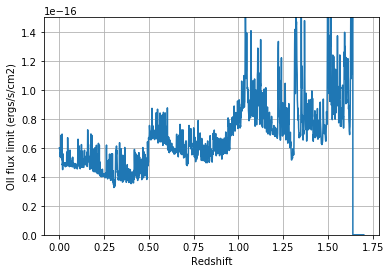

In [3]:
# OII flux limit (FDR), the has-build version should be recomputed but is probably not very different
filename = resource_filename('desisim', 'data/elg_oii_flux_threshold_fdr.txt')
fdr_z, fdr_flux_limit = np.loadtxt(filename, unpack=True)

plt.figure()
plt.plot(fdr_z, fdr_flux_limit)
plt.ylim([0,1.5e-16])
plt.xlabel("Redshift")
plt.ylabel("OII flux limit (ergs/s/cm2)")
plt.grid()

Measured ELG efficiency as a function of rmag and oii flux 

Number of ELGs=28053
(20, 20)


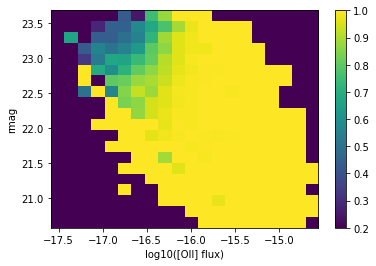

In [4]:
def efficiency2d(x,y,selection,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    h1,xx,yy=np.histogram2d(x[selection],y[selection],bins=(xx,yy))
    print(h0.shape)
    nn=(h0+(h0==0)).astype(float)
    eff=h1/nn
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    tmp=eff*(1-eff)
    tmp=tmp*(tmp>0)+(tmp==0)
    err=np.sqrt(tmp)/np.sqrt(nn)
    err *= (eff<1)
    err += (err<0.01)*0.01
    err += 1000.*(h0==0)
    return xx,yy,eff,err,nn

######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["Z"]>0.6)&(table["Z"]<1.6)
z=table["Z"][elgs]
tz=table["TRUEZ"][elgs]
dz=z-tz
good=(table["ZWARN"][elgs]==0)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)
######################

#good=oiiflux>8e-17 #debug to verify indexation

bins2d=20
rmag=-2.5*np.log10(rflux)+22.5
xx,yy,eff2d,err2d,nn = efficiency2d(np.log10(oiiflux),rmag,good,bins=bins2d)


plt.figure()
plt.imshow(eff2d.T,origin=0,extent=(xx[0],xx[-1],yy[0],yy[-1]),vmin=0.2,aspect="auto")
plt.xlabel("log10([OII] flux)")
plt.ylabel("rmag")
plt.colorbar()

Model

In [5]:
def prof2d(x,y,z,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    hz,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z)
    hz2,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z**2)
    n=(h0+(h0==0)).astype(float)
    z=hz/n
    z2=hz2/n
    var=z2-z**2
    err=np.sqrt(var*(var>0))
    x=xx[:-1]+(xx[1]-xx[0])/2.
    y=yy[:-1]+(yy[1]-yy[0])/2.
    return x,y,z,err

# model ELG efficiency vs rflux and oiiflux
oiiflux = table["OIIFLUX"][elgs]
oiiflux = oiiflux*(oiiflux>=0)+0.00001*(oiiflux<=0)
fluxlimit=np.interp(z,fdr_z,fdr_flux_limit)
fluxlimit[fluxlimit<=0]=1e-20
snr_lines=7*oiiflux/fluxlimit

def elg_efficiency_model_2d(params,log10_snr_lines,rmag) :
    p0 = params[0]
    p1 = params[1]
    p2 = params[2]
    snr_tot  = np.sqrt( (p0*(10**log10_snr_lines))**2 + (p1*10**(-0.4*(rmag-22.5))) **2 )
    return 0.5*(1.+np.erf((snr_tot-3)/(np.sqrt(2.)*p2)))
        
def elg_efficiency_2d_residuals(params,log10_snr_lines,mean_rmag,eff2d,err2d) :
    
    model = elg_efficiency_model_2d(params,log10_snr_lines,mean_rmag)
    res = (eff2d-model)/np.sqrt(err2d**2+0.5**2)
    res = res[err2d<2]
    #chi2 = np.sum(res**2)
    #print("params={} chi2/ndata={}/{}={}".format(params,chi2,res.size,chi2/res.size))
    return res

In [6]:
# 2d fit
#good=snr_lines>4. # debug
#good=rmag<22. # debug
xx,yy,eff2d,err2d,nn = efficiency2d(np.log10(snr_lines),rmag,good)
x1d = xx[:-1]+(xx[1]-xx[0])
y1d = yy[:-1]+(yy[1]-yy[0]) 
x2d=np.tile(x1d,(y1d.size,1)).T
y2d=np.tile(y1d,(x1d.size,1))

params=[1,5,2]
if 0 :
    meff2d=elg_efficiency_model_2d(params,x2d,y2d)
    i=(y2d.ravel()>22.)&(y2d.ravel()<22.4)&(err2d.ravel()<1)
    plt.plot(x2d.ravel()[i],eff2d.ravel()[i],"o")
    plt.plot(x2d.ravel()[i],meff2d.ravel()[i],"o")

(20, 20)


In [7]:
result=scipy.optimize.least_squares(elg_efficiency_2d_residuals,params,args=(x2d,y2d,eff2d,err2d))
params=result.x
print("Best fit parameters for ELG efficiency model:") 
print("SNR_lines = {:4.3f} * 7 * OIIFLUX/limit".format(params[0]))
print("SNR_cont  = {:4.3f} * R_FLUX".format(params[1]))
print("sigma fudge = {:4.3f}".format(params[2]))


Best fit parameters for ELG efficiency model:
SNR_lines = 0.731 * 7 * OIIFLUX/limit
SNR_cont  = 5.609 * R_FLUX
sigma fudge = 1.868


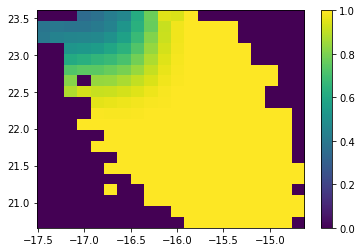

In [8]:
#params[0]=0.001 # no dependence on rmag
meff=elg_efficiency_model_2d(params,np.log10(snr_lines),rmag)
xx,yy,meff2d,merr=prof2d(np.log10(oiiflux),rmag,meff,bins=bins2d)
#plt.imshow(meff2d.T,aspect="auto")
plt.imshow(meff2d.T,origin=0,extent=(xx[0],xx[-1],yy[0],yy[-1]),aspect="auto")
plt.colorbar()

Text(0,0.5,'efficiency')

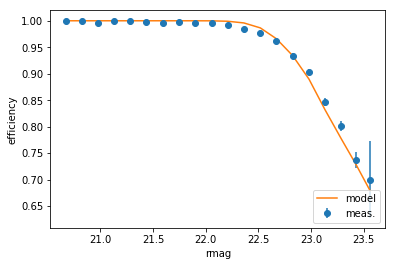

In [9]:
plt.figure()
bins1d=20
x,eff1d,err1d   = efficiency(rmag,good,bins=bins1d)
x,meff1d,merr,nn = prof(rmag,meff,bins=bins1d)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower right")
plt.xlabel("rmag")
plt.ylabel("efficiency")

Text(0,0.5,'efficiency')

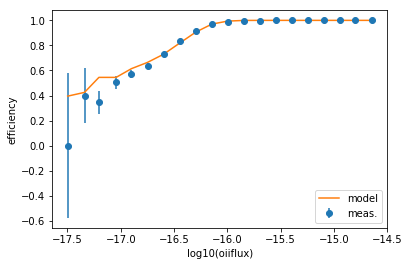

In [10]:
plt.figure()
bins1d=20
x,eff1d,err1d   = efficiency(np.log10(oiiflux),good,bins=bins1d)
x,meff1d,merr,nn = prof(np.log10(oiiflux),meff,bins=bins1d)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower right")
plt.xlabel("log10(oiiflux)")
plt.ylabel("efficiency")

(0.0, 1.4)

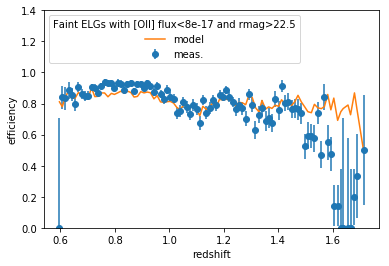

In [11]:
plt.figure()
fcut=8e-17
mcut=22.5
s=(oiiflux<fcut)&(rmag>mcut) # select faint ones to increase contrast in z
bins=100
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint ELGs with [OII] flux<{} and rmag>{}".format(fcut,mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## ELG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of ELGs=28053
ELG redshift error parameters =  [6.43012258e-04 9.35233498e-01]


Text(0,0.5,'rms dz/(1+z)')

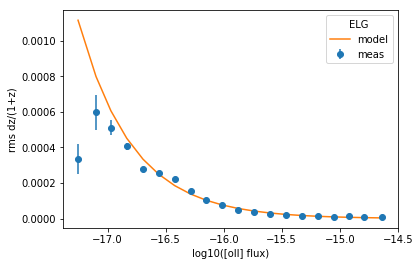

In [12]:
#ELG redshift uncertainty
######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["Z"]>0.6)&(table["Z"]<1.6)
z=table["Z"][elgs]
dz=z-table["TRUEZ"][elgs]
good=(table["ZWARN"][elgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)
lflux=np.log10(oiiflux)
######################

bins=20

binlflux,var,err,nn=prof(lflux[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(binlflux)
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

def redshift_error(params,flux) :
    return params[0]/(1e-9+flux)**params[1]

def redshift_error_residuals(params,flux,rms,rmserror) :
    model = redshift_error(params,flux)
    res = (rms-model)/np.sqrt(rmserror**2+1e-6**2)
    return res
 
#plt.plot(binlflux,rms,"o",label="meas")
plt.errorbar(binlflux,rms,rmserr,fmt="o",label="meas")
params=[0.0006,1.]
binoiiflux=np.array(10**binlflux)
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binoiiflux*1e17,rms,rmserr))
params=result.x
print("ELG redshift error parameters = ",params)
m=redshift_error(params,10**binlflux*1e17)
plt.plot(binlflux,m,"-",label="model")
plt.legend(loc="upper right",title="ELG")
plt.xlabel("log10([oII] flux)")
plt.ylabel("rms dz/(1+z)")

## LRG redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of LRGs=21177
LRG redshift efficiency parameters =  [25.95405065  0.86725807]


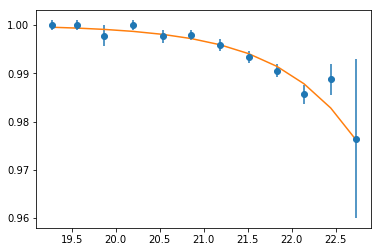

In [22]:
# simply use RFLUX for snr
######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
tz=table["TRUEZ"][lrgs]
dz=z-tz
good=(table["ZWARN"][lrgs]==0)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################

bins=12
bin_rmag,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(bin_rmag,eff,err,fmt="o",label="meas")


def sigmoid(params,x) :
    return 1/(1+np.exp((x-params[0])/params[1]))

def sigmoid_residuals(params,x,y,err) :
    m = sigmoid(params,x)
    res = (m-y)/err
    return res

params=[26.,1.]
result=scipy.optimize.least_squares(sigmoid_residuals,params,args=(bin_rmag,eff,err)) 
params=result.x
plt.plot(bin_rmag,sigmoid(params,bin_rmag),"-")
print("LRG redshift efficiency parameters = ",params)

(0.0, 1.4)

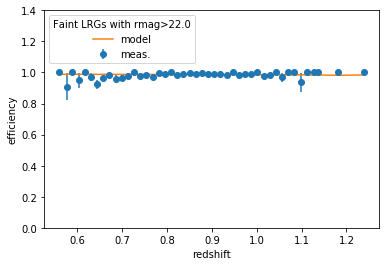

In [25]:
meff=sigmoid(params,rmag)
plt.figure()
mcut=22.
s=(rmag>mcut) # select faint ones to increase contrast in z
bins=50
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint LRGs with rmag>{}".format(mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## LRG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of LRGs=21177
LRG redshift error parameters =  [3.57946732e-04 6.02482440e-01]


Text(0,0.5,'rms dz/(1+z)')

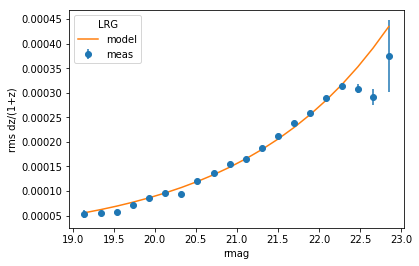

In [14]:
# LRGs redshift uncertainties

######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
tz=table["TRUEZ"][lrgs]
dz=z-tz
good=(table["ZWARN"][lrgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################

bins=20
binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

params=[1.,1.2]
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binflux,rms,rmserr))
params=result.x
print("LRG redshift error parameters = ",params)

model = redshift_error(params,binflux)

plt.errorbar(binmag,rms,rmserr,fmt="o",label="meas")
plt.plot(binmag,model,"-",label="model")
plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")

## QSO (z<2) redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of QSOs=10201
QSO redshift efficiency parameters =  [23.19646567  0.32463827]


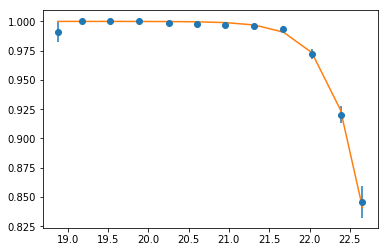

In [16]:
# simply use RFLUX for snr
######################
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["Z"]<2.)
z=table["Z"][qsos]
tz=table["TRUEZ"][qsos]
dz=z-tz
good=(table["ZWARN"][qsos]==0)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################

bins=12
bin_rmag,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(bin_rmag,eff,err,fmt="o",label="meas")
params=[23.,0.3]
result=scipy.optimize.least_squares(sigmoid_residuals,params,args=(bin_rmag,eff,err)) 
params=result.x
plt.plot(bin_rmag,sigmoid(params,bin_rmag),"-")
print("QSO redshift efficiency parameters = ",params)

(0.0, 1.4)

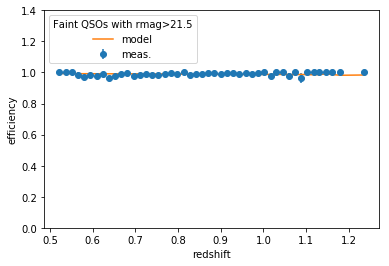

In [26]:
meff=sigmoid(params,rmag)
plt.figure()
mcut=21.5
s=(rmag>mcut) # select faint ones to increase contrast in z
bins=50
x,eff1d,err1d   = efficiency(tz[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(tz[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint QSOs with rmag>{}".format(mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])


## QSO (z<2) redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

In [ ]:
# QSO redshift uncertainties
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["Z"]<2.)
z=table["Z"][qsos]
dz=z-table["TRUEZ"][qsos]
good=(table["ZWARN"][qsos]==0)&(np.abs(dz/(1+z))<0.02)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5


bins=20
binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

params=[1.,1.2]
result=scipy.optimize.least_squares(redshift_error_residuals,params,args=(binflux,rms,rmserr))
params=result.x
print("QSO redshift error parameters = ",params)

model = redshift_error(params,binflux)

plt.errorbar(binmag,rms,rmserr,fmt="o",label="meas")
plt.plot(binmag,model,"-",label="model")
plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")